In [2]:
# JAX implementation of PINNsFormer for 1D Wave Equation
# Based on the paper: "PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks"

import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, value_and_grad
from flax import linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm, trange

dense_kernel_init = nn.initializers.xavier_uniform()
dense_bias_init = nn.initializers.constant(0.01)
# Custom activation function with learnable parameters (Wavelet Activation)
class WaveAct(nn.Module):
    @nn.compact
    def __call__(self, x):
        w1 = self.param('w1', nn.initializers.ones, (1,))
        w2 = self.param('w2', nn.initializers.ones, (1,))
        return w1 * jnp.sin(x) + w2 * jnp.cos(x)

# FeedForward network used in Transformer layers
class FeedForward(nn.Module):
    d_model: int
    d_ff: int = 256

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_ff, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_model, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        return x

class EncoderLayer(nn.Module):
    d_model: int
    num_heads: int

    @nn.compact
    def __call__(self, x):
        # Apply first activation
        x2 = WaveAct()(x)
        
        # Self-Attention: query, key, value all come from x2
        attn_output = nn.SelfAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            use_bias=True,
            dropout_rate=0.1,
            deterministic=True
        )(x2)
        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = WaveAct()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model)(x2)
        
        # Residual connection
        x = x + ff_output
        
        return x



# Decoder layer with cross-attention and feedforward network
class DecoderLayer(nn.Module):
    d_model: int
    num_heads: int

    @nn.compact
    def __call__(self, x, e_outputs):
        # Apply first activation
        x2 = WaveAct()(x)
        
        # Cross-Attention: query from decoder, key & value from encoder
        cross_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.d_model,
            use_bias=True,
            dropout_rate=0.1,
            deterministic=True
        )
        attn_output = cross_attn(query=x2, key=e_outputs, value=e_outputs)
        
        # Residual connection
        x = x + attn_output
        
        # Apply second activation
        x2 = WaveAct()(x)
        
        # Feedforward network
        ff_output = FeedForward(d_model=self.d_model)(x2)
        
        # Residual connection
        x = x + ff_output
        
        return x


# Encoder consisting of multiple encoder layers
class Encoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int

    @nn.compact
    def __call__(self, x):
        for _ in range(self.N):
            x = EncoderLayer(self.d_model, self.num_heads)(x)
        x = WaveAct()(x)
        return x

# Decoder consisting of multiple decoder layers
class Decoder(nn.Module):
    d_model: int
    N: int  # Number of layers
    num_heads: int

    @nn.compact
    def __call__(self, x, e_outputs):
        for _ in range(self.N):
            x = DecoderLayer(self.d_model, self.num_heads)(x, e_outputs)
        x = WaveAct()(x)
        return x

# PINNsFormer model combining the encoder and decoder
class PINNsformer(nn.Module):
    d_out: int
    d_hidden: int
    d_model: int
    N: int  # Number of encoder/decoder layers
    num_heads: int

    @nn.compact
    def __call__(self, x_seq, t_seq):


        # x_seq and t_seq have shape (batch_size, seq_len, 1)
        src = jnp.concatenate([x_seq, t_seq], axis=-1)  # Shape: (batch_size, seq_len, 2)
        src = nn.Dense(self.d_model)(src)  # Spatio-temporal mixer
        e_outputs = Encoder(self.d_model, self.N, self.num_heads)(src)
        d_output = Decoder(self.d_model, self.N, self.num_heads)(src, e_outputs)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(d_output)
        x = WaveAct()(x)
        x = nn.Dense(self.d_hidden, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)
        x = WaveAct()(x)
        x = nn.Dense(self.d_out, kernel_init=dense_kernel_init, bias_init=dense_bias_init)(x)  # Output layer
        return x  # Shape: (batch_size, seq_len, d_out)

# Function to generate training and boundary data
def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)
    x_mesh, t_mesh = np.meshgrid(x, t)
    data = np.stack([x_mesh.flatten(), t_mesh.flatten()], axis=-1)

    b_left = data[np.isclose(x_mesh.flatten(), x_range[0])]
    b_right = data[np.isclose(x_mesh.flatten(), x_range[1])]
    b_upper = data[np.isclose(t_mesh.flatten(), y_range[1])]
    b_lower = data[np.isclose(t_mesh.flatten(), y_range[0])]

    return data, b_left, b_right, b_upper, b_lower

# Function to create time sequences for inputs
def make_time_sequence(src, num_step=5, step=1e-4):
    # src shape: (N, 2)
    N = src.shape[0]
    seq = np.tile(src[:, None, :], (1, num_step, 1))  # (N, seq_len, 2)
    for i in range(num_step):
        seq[:, i, -1] += step * i
    return seq  # Shape: (N, seq_len, 2)

# Function to count the number of parameters in the model
def get_n_params(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])

# Generate training data
res, b_left, b_right, b_upper, b_lower = get_data([0, 1], [0, 1], 51, 51)
res_test, _, _, _, _ = get_data([0, 1], [0, 1], 101, 101)

# Create pseudo sequences
num_step = 5
delta_t = 1e-4
res_seq = make_time_sequence(res, num_step=num_step, step=delta_t)
b_left_seq = make_time_sequence(b_left, num_step=num_step, step=delta_t)
b_right_seq = make_time_sequence(b_right, num_step=num_step, step=delta_t)
b_upper_seq = make_time_sequence(b_upper, num_step=num_step, step=delta_t)
b_lower_seq = make_time_sequence(b_lower, num_step=num_step, step=delta_t)

# Convert data to JAX arrays
res_seq = jnp.array(res_seq)
b_left_seq = jnp.array(b_left_seq)
b_right_seq = jnp.array(b_right_seq)
b_upper_seq = jnp.array(b_upper_seq)
b_lower_seq = jnp.array(b_lower_seq)

# Extract x and t sequences
x_res_seq, t_res_seq = res_seq[:, :, 0:1], res_seq[:, :, 1:2]
x_left_seq, t_left_seq = b_left_seq[:, :, 0:1], b_left_seq[:, :, 1:2]
x_right_seq, t_right_seq = b_right_seq[:, :, 0:1], b_right_seq[:, :, 1:2]
x_upper_seq, t_upper_seq = b_upper_seq[:, :, 0:1], b_upper_seq[:, :, 1:2]
x_lower_seq, t_lower_seq = b_lower_seq[:, :, 0:1], b_lower_seq[:, :, 1:2]

# Initialize model and optimizer
key = random.PRNGKey(0)
model = PINNsformer(d_out=1, d_hidden=32, d_model=32, N=1, num_heads=2)

# For initialization, we can use a subset of the data
init_x = x_res_seq[:64]  # Shape: (64, seq_len, 1)
init_t = t_res_seq[:64]  # Shape: (64, seq_len, 1)
variables = model.init(key, init_x, init_t)

# Use Adam optimizer
learning_rate = 1e-3
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(variables)

n_params = get_n_params(variables)
print(f"Number of parameters: {n_params}")

pi = jnp.pi

def loss_fn(params, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    # Compute u_seq over residual points
    u_seq = model.apply(params, x_res_seq, t_res_seq)
    
    # Compute u_tt_seq and u_xx_seq
    u_tt_seq = compute_u_tt(params, x_res_seq, t_res_seq)
    u_xx_seq = compute_u_xx(params, x_res_seq, t_res_seq)
    
    # Compute residual loss over all time steps
    residual = u_tt_seq - 4 * u_xx_seq  # Shape: (batch_size, seq_len, 1)
    loss_res = jnp.mean(residual ** 2)
    
    # Boundary conditions over sequences
    pred_upper_seq = model.apply(params, x_upper_seq, t_upper_seq)
    pred_lower_seq = model.apply(params, x_lower_seq, t_lower_seq)
    loss_bc = jnp.mean(pred_upper_seq ** 2) + jnp.mean(pred_lower_seq ** 2)
    
    # Initial conditions (only first time step)
    x_left = x_left_seq[:, 0, :]  # Shape: (batch_size, 1)
    t_left = t_left_seq[:, 0, :]  # Should be t=0
    pred_left = model.apply(params, x_left_seq[:, 0:1, :], t_left_seq[:, 0:1, :]).squeeze()  # Shape: (batch_size,)
    # Compute initial condition u(x,0)
    x_left_flat = x_left.squeeze()
    initial_condition = jnp.sin(pi * x_left_flat) + 0.5 * jnp.sin(3 * pi * x_left_flat)
    loss_ic_1 = jnp.mean((pred_left - initial_condition) ** 2)
    
    # Compute du/dt at t=0
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    ui_t = vmap(lambda x, t: grad(u_fn_scalar, argnums=1)(x, t))(x_left_flat, t_left.squeeze())
    loss_ic_2 = jnp.mean(ui_t ** 2)
    loss_ic = loss_ic_1 + loss_ic_2
    
    # Total loss
    loss = loss_res + loss_ic + loss_bc

    # Prepare auxiliary outputs and stop gradients
    aux = (jax.lax.stop_gradient(loss_res), jax.lax.stop_gradient(loss_ic), jax.lax.stop_gradient(loss_bc))
    
    return loss, aux



# Functions to compute second-order derivatives
def compute_u_tt(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_t_fn(x, t):
        return grad(u_fn_scalar, argnums=1)(x, t)
    
    def u_tt_fn(x, t):
        return grad(u_t_fn, argnums=1)(x, t)
    
    u_tt_flat = vmap(u_tt_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_tt_seq = u_tt_flat.reshape(x_seq.shape)
    return u_tt_seq

def compute_u_xx(params, x_seq, t_seq):
    x_seq_flat = x_seq.reshape(-1, 1)
    t_seq_flat = t_seq.reshape(-1, 1)
    
    def u_fn_scalar(x, t):
        x = x.reshape(1, 1, 1)
        t = t.reshape(1, 1, 1)
        u = model.apply(params, x, t)
        return u.squeeze()
    
    def u_x_fn(x, t):
        return grad(u_fn_scalar, argnums=0)(x, t)
    
    def u_xx_fn(x, t):
        return grad(u_x_fn, argnums=0)(x, t)
    
    u_xx_flat = vmap(u_xx_fn)(x_seq_flat.squeeze(), t_seq_flat.squeeze())
    u_xx_seq = u_xx_flat.reshape(x_seq.shape)
    return u_xx_seq

# Create a function to compute the loss and gradients
@jit
def train_step(params, opt_state, x_res_seq, t_res_seq, x_left_seq, t_left_seq, x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq):
    (loss_value, aux), grads = value_and_grad(loss_fn, has_aux=True)(
        params, x_res_seq, t_res_seq, x_left_seq, t_left_seq,
        x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq
    )
    loss_res, loss_ic, loss_bc = aux
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, loss_res, loss_ic, loss_bc


# Training loop
loss_track = []
params = variables

from tqdm import trange

num_epochs = 1000
pbar = trange(num_epochs)
for i in pbar:
    params, opt_state, loss_value, loss_res, loss_ic, loss_bc = train_step(
        params, opt_state, x_res_seq, t_res_seq, x_left_seq, t_left_seq,
        x_right_seq, t_right_seq, x_upper_seq, t_upper_seq, x_lower_seq, t_lower_seq
    )
    loss_track.append(loss_value)
    pbar.set_postfix({'Loss': float(loss_value), 'Res': float(loss_res), 'IC': float(loss_ic), 'BC': float(loss_bc)})


print(f"Final Loss: {loss_track[-1]}")


plt.plot(loss_track)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model parameters
import pickle
with open('1dwave_pinnsformer_params.pkl', 'wb') as f:
    pickle.dump(params, f)




TypeError: __call__() got an unexpected keyword argument 'query'

100%|██████████| 11/11 [00:01<00:00,  9.35it/s]


Relative L1 error: 1.2390379905700684
Relative L2 error: 1.2118273973464966


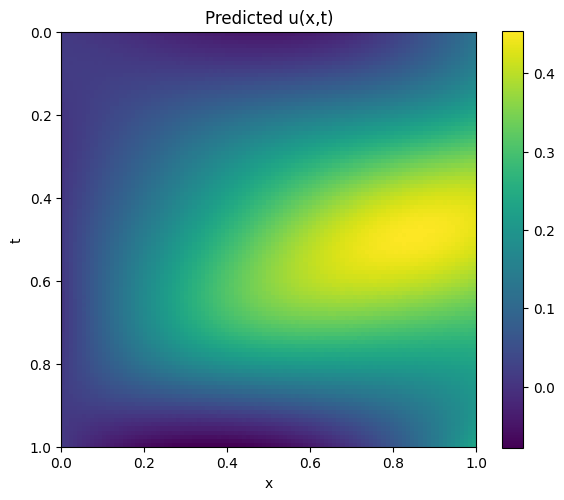

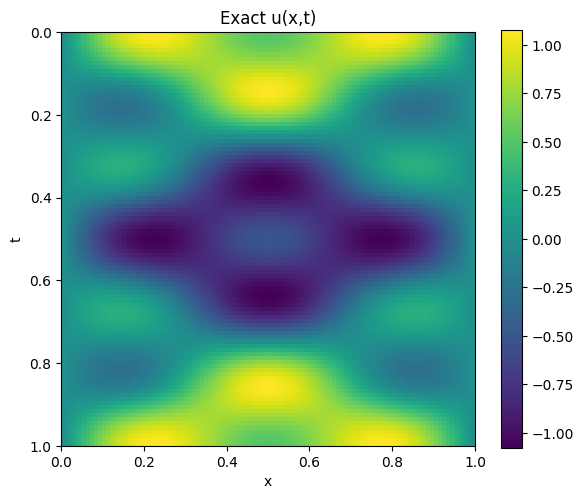

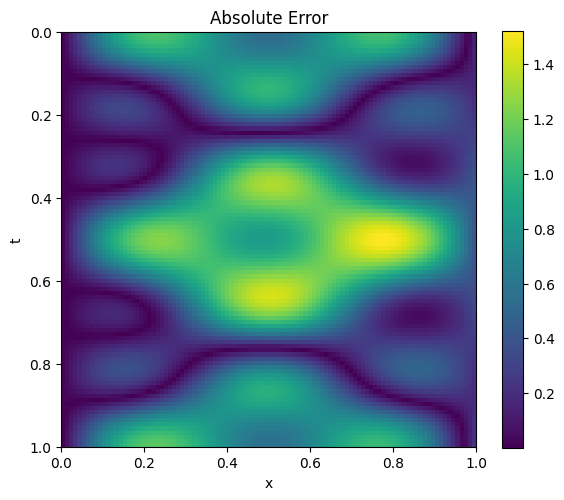

In [8]:
# # Save the trained model parameters
# import pickle
# with open('1dwave_pinnsformer_params.pkl', 'rb') as f:
#     params = pickle.load(f)

# Visualization
res_test_seq = make_time_sequence(res_test, num_step=1, step=1e-3)
res_test_seq = jnp.array(res_test_seq)
x_test_seq, t_test_seq = res_test_seq[:, :, 0:1], res_test_seq[:, :, 1:2]
x_test_flat = x_test_seq.reshape(-1, 1, 1)
t_test_flat = t_test_seq.reshape(-1, 1, 1)

# Predict using the trained model in batches
def predict(params, x_seq, t_seq):
    pred_seq = model.apply(params, x_seq, t_seq)
    return pred_seq

batch_size = 1000
num_samples = x_test_flat.shape[0]
predictions = []
for i in tqdm(range(0, num_samples, batch_size)):
    x_batch = x_test_flat[i:i+batch_size]
    t_batch = t_test_flat[i:i+batch_size]
    pred_batch = predict(params, x_batch, t_batch).squeeze()
    predictions.append(np.array(pred_batch))

pred = np.concatenate(predictions, axis=0)
grid_size = int(np.sqrt(pred.shape[0]))
pred = pred.reshape(grid_size, grid_size)

# Exact solution
def u_ana(x, t):
    return np.sin(np.pi * x) * np.cos(2 * np.pi * t) + 0.5 * np.sin(3 * np.pi * x) * np.cos(6 * np.pi * t)

res_test_flat = res_test_seq[:, 0, :]  # Only first time step
u_exact = u_ana(res_test_flat[:, 0], res_test_flat[:, 1]).reshape(grid_size, grid_size)

# Compute relative errors
rl1 = np.sum(np.abs(u_exact - pred)) / np.sum(np.abs(u_exact))
rl2 = np.sqrt(np.sum((u_exact - pred) ** 2) / np.sum(u_exact ** 2))

print(f"Relative L1 error: {rl1}")
print(f"Relative L2 error: {rl2}")

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(pred, extent=[0, 1, 1, 0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinnsformer_pred.png')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(u_exact, extent=[0, 1, 1, 0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_exact.png')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(np.abs(pred - u_exact), extent=[0, 1, 1, 0], cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinnsformer_error.png')
plt.show()

# Pytorch

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import copy

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        # pdb.set_trace()
        # raise Exception('stop')
        return output

def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_data_3d(x_range, y_range, t_range, x_num, y_num, t_num):
    step_x = (x_range[1] - x_range[0]) / float(x_num-1)
    step_y = (y_range[1] - y_range[0]) / float(y_num-1)
    step_t = (t_range[1] - t_range[0]) / float(t_num-1)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]

    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    res = data.reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[0]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_left = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[1]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_right = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[0]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_lower = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[1]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_upper = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    return res, b_left, b_right, b_upper, b_lower


seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

step_size = 1e-4


# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,1], 51, 51)
res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)

res = make_time_sequence(res, num_step=5, step=step_size)
b_left = make_time_sequence(b_left, num_step=5, step=step_size)
b_right = make_time_sequence(b_right, num_step=5, step=step_size)
b_upper = make_time_sequence(b_upper, num_step=5, step=step_size)
b_lower = make_time_sequence(b_lower, num_step=5, step=step_size)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,:,0:1], res[:,:,1:2]
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2]
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2]
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2]
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

# optim = Adam(model.parameters(), lr=1e-4)

n_params = get_n_params(model)



loss_track = []

pi = torch.tensor(np.pi, dtype=torch.float32, requires_grad=False).to(device)

for i in tqdm(range(1000)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_tt - 4 * u_xx) ** 2)
        loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower) ** 2)

        ui_t = torch.autograd.grad(pred_left, t_left, grad_outputs=torch.ones_like(pred_left), retain_graph=True, create_graph=True)[0]

        loss_ic_1 = torch.mean((pred_left[:,0] - torch.sin(pi*x_left[:,0]) - 0.5 * torch.sin(3*pi*x_left[:,0])) ** 2)
        loss_ic_2 = torch.mean((ui_t)**2)

        loss_ic = loss_ic_1 + loss_ic_2

        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
        
        loss = loss_res + loss_ic + loss_bc
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)


/tmp/ipykernel_361874/2928888497.py:221: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

  0%|          | 0/1000 [00:00<?, ?it/s]/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 21%|██▏       | 213/1000 [15:26<57:02,  4.35s/it]  


KeyboardInterrupt: 

Loss Res: 0.005495, Loss_BC: 0.024451, Loss_IC: 0.021561
Train Loss: 0.051507
relative L1 error: 0.436792
relative L2 error: 0.430833


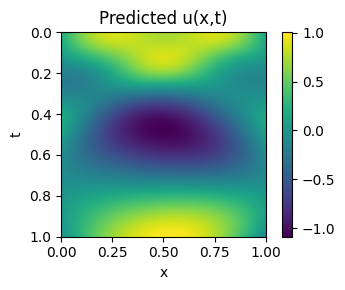

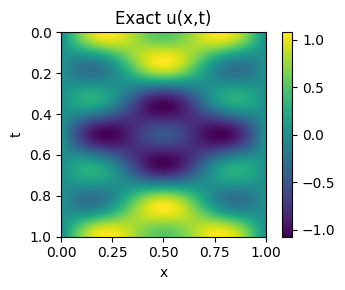

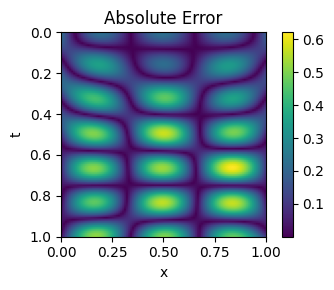

In [3]:

print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dwave_pinnsformer.pt')

# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=step_size) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

def u_ana(x,t):
    return np.sin(np.pi*x) * np.cos(2*np.pi*t) + 0.5 * np.sin(3*np.pi*x) * np.cos(6*np.pi*t)

res_test, _, _, _, _ = get_data([0,1], [0,1], 101, 101)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinnsformer_pred.png')
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_exact.png')
plt.show()

plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinnsformer_error.png')
plt.show()